# Winning

Whether it's Charlie Sheen or an NFL franchise, winning is seen as the single most important objective. But unlike Charlie Sheen, NFL teams need more than tiger blood. In this study, I am going to examine which are the most important offensive factors that give a team the best chance to win a game. Additionally, I want to see if those factors are as important in the playoffs as they are in the regular season. 

## Hypothesis

The recent trend has been to throw on first, second, and third down and rush once in a while to keep the opposing defenses honest. While that works in the regular season, in the playoffs, a team needs a more balanced attack to win.

## Method

I will gather offensive stats from the past 10 NFL seasons. They will be divided into regular season and postseason(playoff) games. Each NFL season has 256 games (16 games/week x 16 weeks/season) for a total of 2560 games in 10 seasons as a pool from which we will randomly sample 1000 games. In the postseason, 12 teams qualify and play a total of 11 games(4-wild card, 4-divisional, 2-conference, and the Super Bowl). That equates to 110 postseason games which would be roughly 10% of the size of the training dataset. I will first compare our model to the regular season games to establish a baseline of accuracy then compare how the same model performs in the playoffs.

## Data

The method which I will be gathering the data will be by brute force which will be a bit labor-intensive. I will be using the website www.pro-football-reference.com to convert the game stats to csv by copying the offense and defense game data on to a spreadsheet and then exporting it as a .csv file.

In [2]:
# Let's load the necessary packages and the data
import numpy as np
import pandas as pd
import pandas_profiling
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
import pprint

### Offense Dataset

In [3]:
# import data
col_names = ['win', 'home_game', 'score', 'opp_score', 'completions', 'pass_att', 'pass_yds', 'pass_tds',
              'interceptions', 'sacks', 'yds_lost', 'yds_per_pass_att', 'comp_%', 'qb_rtg',
              'rush_att', 'rush_yds', 'yds_per_rush_att', 'rush_tds', 'fgs_made', 'fg_att',
              'x_pts_made', 'x_pt_att', 'punts', 'punt_yds', '3_down_conv', '3_down_att', 
              '4_down_conv', '4_down_att', 'time_of_poss']

offense = pd.read_csv('../../../Data/offense.csv', header=None, names=col_names)
#offense.head(5)

Let's fix the 'win' and 'venue' columns.

In [4]:
# first change 'win' column values from string to number type
offense['win'] = np.where(offense['win'] == 'W', 1, 0)

# change venue to more descriptive value 0=away, 1=home
offense['home_game'] = np.where(offense['home_game'] == '@', 0, 1)

# we don't need to know the opponent's score for the offensive model so let's drop that column
offense = offense.drop(['opp_score'], axis=1)

display(offense.head(5))

,win,home_game,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,1,16,26,44,259,1,2,3,29,...,3,1,1,6,328,4,14,0,1,28:23
1,1,0,31,27,32,265,2,0,0,0,...,2,4,4,3,139,2,9,1,1,31:21
2,0,1,21,27,46,226,2,5,2,16,...,0,3,3,4,210,4,10,1,2,27:02
3,1,0,41,22,33,256,5,1,1,5,...,2,5,5,4,166,8,14,0,0,33:16
4,1,1,31,29,38,340,2,0,0,0,...,1,4,4,7,364,2,12,1,2,31:30


That leaves us with the last column in the dataframe that contains the time of possession value as a string. We would need to convert these to numerical values to be able to get meaningful information.

In [5]:
# change 'time_of_poss' values to duration in seconds
# check to see if any values are different than mm:ss
print(offense[offense['time_of_poss'].str.len() < 5])

     win  home_game  score  completions  pass_att  pass_yds  pass_tds  \
19     0          0      7           30        53       201         1   
35     1          1     23           22        40       257         1   
51     0          0     13           19        34       207         1   
67     0          1     20           28        49       399         2   
82     0          0     17           23        40       299         2   
98     0          1      6           20        43       205         1   
287    1          0     21           11        19        90         0   
547    0          0     16           18        32       207         1   

     interceptions  sacks  yds_lost  ...  fg_att  x_pts_made  x_pt_att  punts  \
19               2      6        41  ...       0           1         1      8   
35               1      2        14  ...       3           2         2      7   
51               1      2        18  ...       2           1         1      6   
67               1

In [6]:
# fix incomplete data
offense.at[19, 'time_of_poss'] = '32:40'
offense.at[35, 'time_of_poss'] = '35:00'
offense.at[51, 'time_of_poss'] = '23:50'
offense.at[67, 'time_of_poss'] = '32:00'
offense.at[82, 'time_of_poss'] = '30:30'
offense.at[98, 'time_of_poss'] = '23:20'
offense.at[287, 'time_of_poss'] = '27:00'
offense.at[547, 'time_of_poss'] = '32:20'

In [7]:
# first need to change the format from mm:ss to hh:mm:ss
offense['time_of_poss'] = ['00:' + x for x in offense['time_of_poss']]
# print(offense['time_of_poss'])

In [8]:
# convert strings to seconds 
offense['time_of_poss'] = pd.to_timedelta(offense['time_of_poss'], 'seconds')

In [9]:
# convert to seconds(float)
offense['time_of_poss'] = offense['time_of_poss'].dt.total_seconds()

In [10]:
# print(offense['time_of_poss'])

In [11]:
# Let's gather some stats on the stats
pandas_profiling.ProfileReport(offense)

Number of variables,28
Number of observations,1000
Total Missing (%),0.0%
Total size in memory,218.8 KiB
Average record size in memory,224.1 B
Numeric,23
Categorical,0
Boolean,2
Date,0
Text (Unique),0
Rejected,3


In [12]:
# post season offense data
post_off = pd.read_csv('../../../Data/postoffense.csv', header=None, names=col_names)
post_off.head(5)

,win,home_game,score,opp_score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,L,NaN,14,24,18,36,110,1,1,3,...,2,2,2,4,192,5,14,0,1,26:58
1,W,NaN,34,14,23,35,228,2,0,2,...,2,4,4,6,229,9,16,0,0,39:34
2,W,@,33,14,4,10,34,0,1,0,...,2,3,3,4,136,10,16,0,0,32:21
3,W,NaN,51,45,29,33,375,5,0,1,...,2,6,6,1,26,3,5,0,0,31:27
4,W,NaN,45,14,23,32,247,3,0,0,...,1,6,6,4,171,7,13,0,1,36:27


In [13]:
print(post_off[post_off['time_of_poss'].str.len() < 5])

Empty DataFrame
Columns: [win, home_game, score, opp_score, completions, pass_att, pass_yds, pass_tds, interceptions, sacks, yds_lost, yds_per_pass_att, comp_%, qb_rtg, rush_att, rush_yds, yds_per_rush_att, rush_tds, fgs_made, fg_att, x_pts_made, x_pt_att, punts, punt_yds, 3_down_conv, 3_down_att, 4_down_conv, 4_down_att, time_of_poss]
Index: []

[0 rows x 29 columns]


I guess I did a better job of data entry on the playoff dataset. Whew!

In [14]:
# first change 'win' column values from string to number type
post_off['win'] = np.where(post_off['win'] == 'W', 1, 0)

# change venue to more descriptive value 0=away, 1=home
post_off['home_game'] = np.where(post_off['home_game'] == '@', 0, 1)

# we don't need to know the opponent's score for the offensive model so let's drop that column
post_off = post_off.drop(['opp_score'], axis=1)

# first need to change the format from mm:ss to hh:mm:ss
post_off['time_of_poss'] = ['00:' + x for x in post_off['time_of_poss']]

# convert strings to seconds 
post_off['time_of_poss'] = pd.to_timedelta(post_off['time_of_poss'], 'seconds')

# convert to seconds(float)
post_off['time_of_poss'] = post_off['time_of_poss'].dt.total_seconds()

post_off.head(5)

,win,home_game,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
0,0,1,14,18,36,110,1,1,3,36,...,2,2,2,4,192,5,14,0,1,1618.0
1,1,1,34,23,35,228,2,0,2,16,...,2,4,4,6,229,9,16,0,0,2374.0
2,1,0,33,4,10,34,0,1,0,0,...,2,3,3,4,136,10,16,0,0,1941.0
3,1,1,51,29,33,375,5,0,1,4,...,2,6,6,1,26,3,5,0,0,1887.0
4,1,1,45,23,32,247,3,0,0,0,...,1,6,6,4,171,7,13,0,1,2187.0


## Visualizations

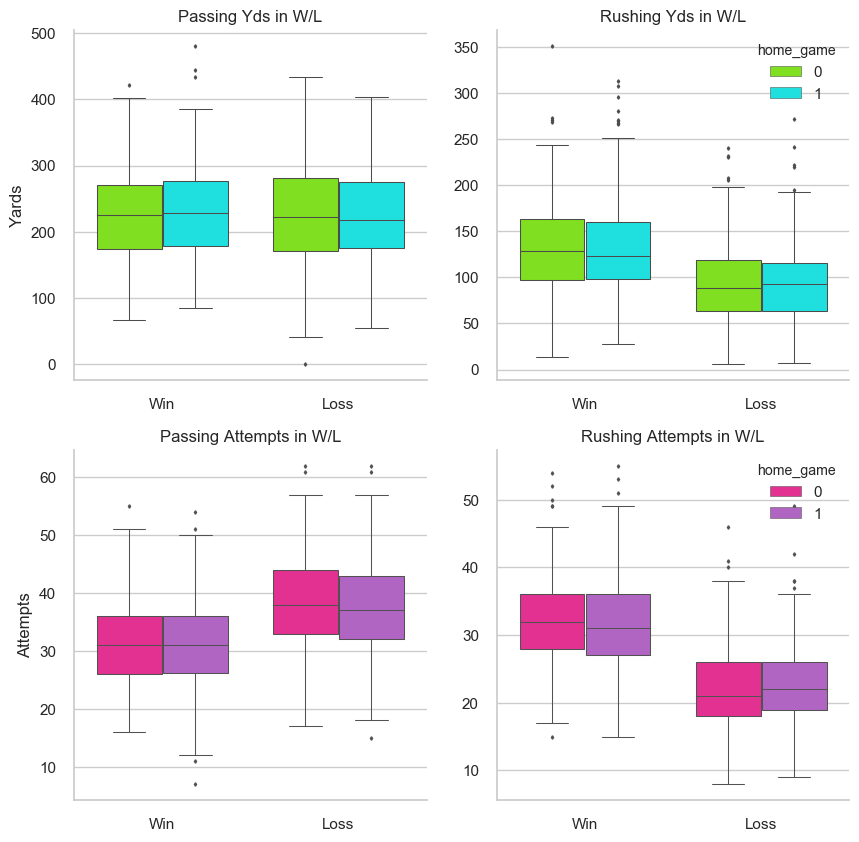

In [16]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.set(style='whitegrid')
sns.despine()

x = 'win'
hue = 'home_game'

ax1 = axes[0, 0]
sns.boxplot(x=x, y='pass_yds', hue=hue, data=offense, order=[1, 0], ax=ax1, palette=['chartreuse', 'aqua'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax1.set_title('Passing Yds in W/L')
ax1.set_ylabel('Yards')
ax1.set_xlabel('')
ax1.get_legend().remove()
ax1.set_xticklabels(['Win', 'Loss'])

ax2 = axes[0, 1]
sns.boxplot(x=x, y='rush_yds', hue=hue, data=offense, order=[1, 0], ax=ax2, palette=['chartreuse', 'aqua'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax2.set_title('Rushing Yds in W/L')
ax2.set_ylabel('')
ax2.set_xlabel('')
ax2.set_xticklabels(['Win', 'Loss'])

ax3 = axes[1, 0]
sns.boxplot(x=x, y='pass_att', hue=hue, data=offense, order=[1, 0], ax=ax3, palette=['deeppink', 'mediumorchid'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax3.set_title('Passing Attempts in W/L')
ax3.set_ylabel('Attempts')
ax3.set_xlabel('')
ax3.get_legend().remove()
ax3.set_xticklabels(['Win', 'Loss'])

ax4 = axes[1, 1]
sns.boxplot(x=x, y='rush_att', hue=hue, data=offense, order=[1, 0], ax=ax4, palette=['deeppink', 'mediumorchid'],
            width=0.75, linewidth=0.75, fliersize=1.75)
ax4.set_title('Rushing Attempts in W/L')
ax4.set_ylabel('')
ax4.set_xlabel('')
ax4.set_xticklabels(['Win', 'Loss'])

plt.show()

That is certainly interesting. Passing yards doesn't show much difference between wins and losses, but there definitely is a trend of winning teams gaining more rush yards than losing teams. If you were to look at just the plots of passing and rushing attempts, one would think that rushing is more important in winning than passing. We need to dig deeper.

I have noticed something a little strange in the top left plot. There seems to a game that recorded 0 pass yards. Is that even possible? I want to track this down to make sure that it isn't an erroneous record.

In [17]:
# find the record that has 0 passing yards
no_pass_yds = offense[offense['pass_yds'] == 0]
display(no_pass_yds)

,win,home_game,score,completions,pass_att,pass_yds,pass_tds,interceptions,sacks,yds_lost,...,fg_att,x_pts_made,x_pt_att,punts,punt_yds,3_down_conv,3_down_att,4_down_conv,4_down_att,time_of_poss
862,0,0,0,4,19,0,0,1,3,31,...,0,0,0,7,275,1,11,1,1,1126.0


Ahh. So it looks like this definitely wasn't an erroneous record. This team completed only 4 passes in 19 passing attempts in a shutout loss. Definitely won't win too many games with this kind of offense. I have a strong suspicion that this was a 16-loss team (read: Browns or Raiders) game that went horribly wrong. Or maybe, just maybe, it could be a relic of dark times in my Broncos' history that was Tim Tebow-led offense that still gives me the shudders to this day everytime I think about it.

Speaking of quarterbacks, it's been said that in football, the quarterback gets all the credit when the team does well, but also gets the lion's share of the blame when it does terribly. So let's see if that bears out in our next plot.

Text(0.5, 1, 'Number of wins and losses by passing tds')

<Figure size 800x550 with 0 Axes>

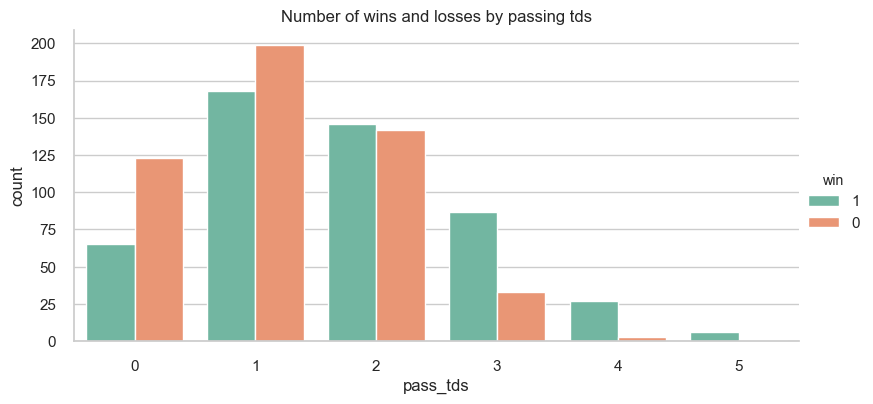

In [18]:
# plot pass touchdowns and wins
sns.set(style='whitegrid')
sns.despine()
sns.catplot(x='pass_tds', hue='win', data=offense, kind='count', height=4, aspect=2, palette='Set2', hue_order=[1, 0])
plt.title('Number of wins and losses by passing tds')

<Figure size 800x550 with 0 Axes>

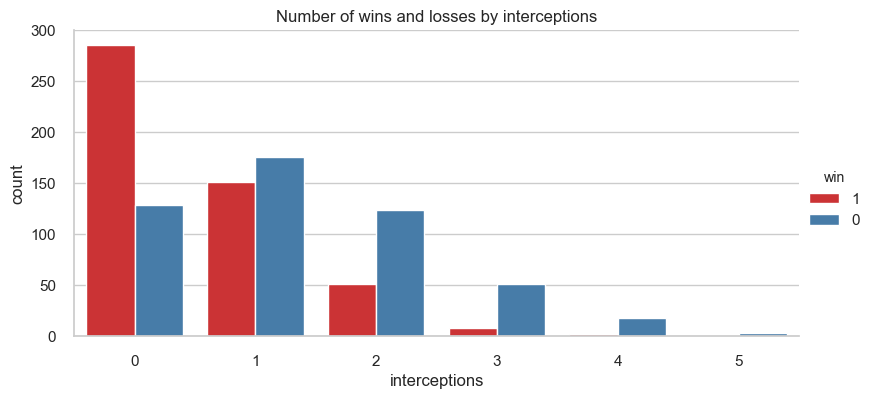

In [19]:
# plot interceptions and wins
sns.set(style='whitegrid')
sns.despine()
sns.catplot(x='interceptions', hue='win', data=offense, kind='count', height=4, aspect=2, palette='Set1',
            hue_order=[1, 0])

plt.title('Number of wins and losses by interceptions')
plt.show()

Naturally, there will be a smaller number of games in which there were 3+ touchdowns or interceptions, but what we want to pay attention to is the ratio of wins to losses for each case. As number of touchdowns increased, wins-to-losses ratio went up and vice versa for interceptions. So it does seem that the quarterback performance does affect the outcome of the game.

Since we are dealing with sports statistic, it is inevitable that certain varaibles will be closely correlated. The score will obviously be correlated to touchdowns scored, pass yards will be correlated to pass completions and so on. I want to plot each to quantify to relationships and see if we can eliminate some that are highly correlated, thus redundant.

### Correlation Matrix

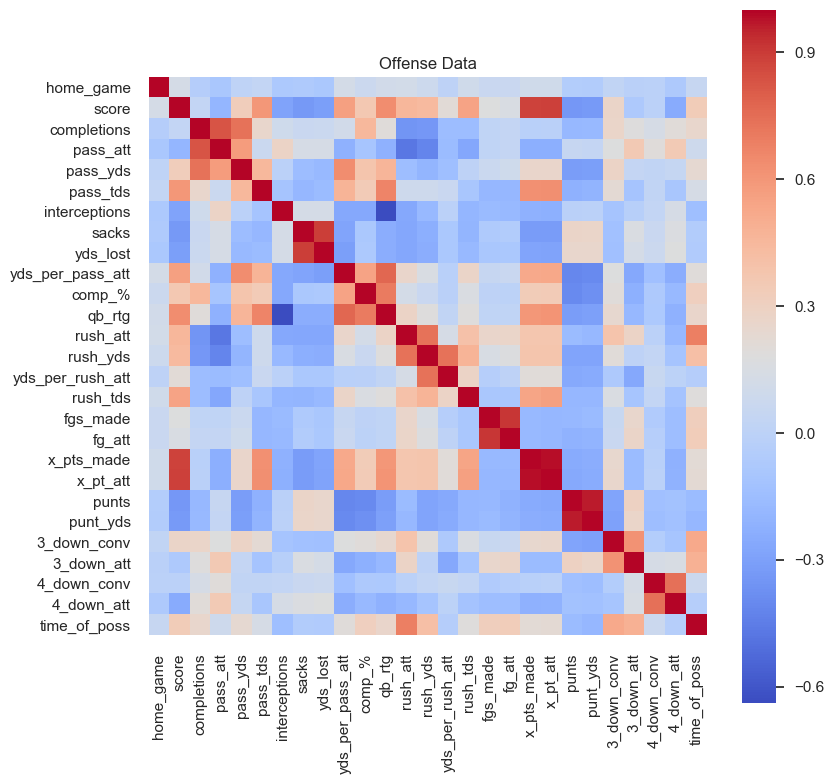

In [20]:
# Let's pull the relevant data from the table and store it
off_features = offense.drop(['win'], axis=1)

# Let's plot a matrix
corrmat = off_features.corr()

plt.subplots(figsize=(9, 9))
sns.heatmap(data=corrmat, cmap="coolwarm", square=True)
plt.title('Offense Data')
plt.show()

This isn't too terrible. There are less highly correlated variables than I had thought. Let's list the ones that need to be examined more closely. 

1. x_pts_made & score
2. x_pt_att & score
3. rush_att & pass_att
4. qb_rtg & interceptions
5. pass_att & completions
6. yds_lost & sacks
7. punts & yds_per_pass_att
8. fg_att & fgs_made
9. x_pt_att & x_pts_made
10. punt_yds & punts

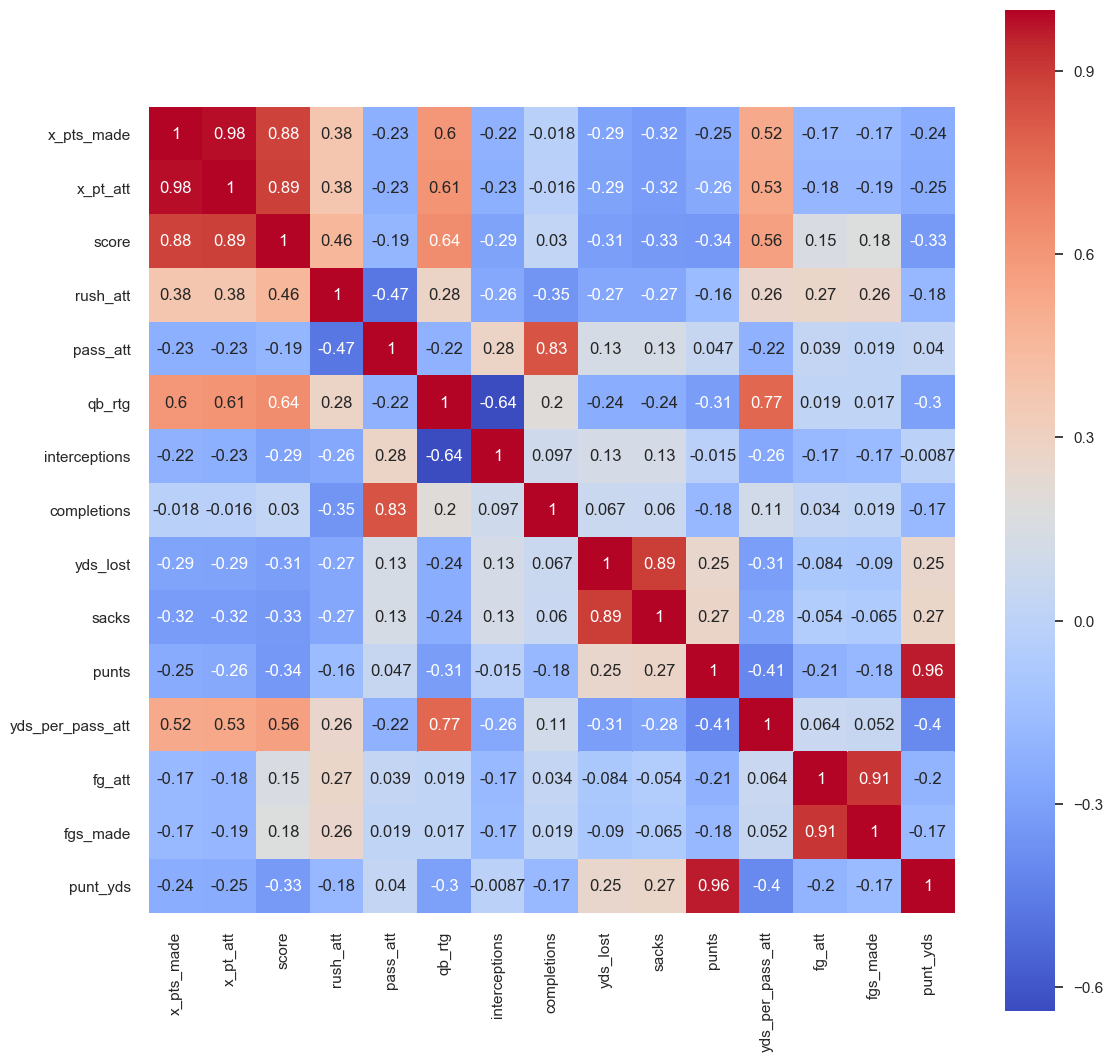

In [21]:
# Get correlation between above columns
# first make a list of columns
corr_col = ['x_pts_made', 'x_pt_att', 'score', 'rush_att', 'pass_att', 'qb_rtg', 'interceptions', 'completions',
            'yds_lost', 'sacks', 'punts', 'yds_per_pass_att', 'fg_att', 'fgs_made', 'punt_yds']

filtered_corr = offense[corr_col].corr()

plt.subplots(figsize=(13, 13))
sns.heatmap(data=filtered_corr, cmap='coolwarm', square=True, annot=True)

In [22]:
#Let's drop the columns that have a correlation of 0.6 or higher. 
off_features = off_features.drop(['score', 'x_pt_att', 'pass_att', 'qb_rtg', 'yds_lost', 'punts', 'fg_att'], axis=1)
off_features.columns

Index(['home_game', 'completions', 'pass_yds', 'pass_tds', 'interceptions',
       'sacks', 'yds_per_pass_att', 'comp_%', 'rush_att', 'rush_yds',
       'yds_per_rush_att', 'rush_tds', 'fgs_made', 'x_pts_made', 'punt_yds',
       '3_down_conv', '3_down_att', '4_down_conv', '4_down_att',
       'time_of_poss'],
      dtype='object')

Let's move forward now with these features and build a model that can predict the wins.

## Models

Now to the fun part! Our target variable is either a win or a loss. So I will employ different classification models to see which performs the best. 

In [23]:
# designate dependent and independent variables
X = off_features
y = offense['win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(800, 20) (200, 20) (800,) (200,)


In [24]:
# Naive-Bayes classifier
nb_results = ['Naive-Bayes']

# start timer
start_time = time.time()

# train model
bn = BernoulliNB()
bn_model = bn.fit(X_train, y_train)

# stop timer
elapsed = time.time() - start_time
nb_results.append('%0.4f' % elapsed)

# validate model
cvs = cross_val_score(bn_model, X_train, y_train, cv=10)
nb_results.append('%0.4f' % np.mean(cvs))

# make predictions
y_pred = bn_model.predict(X_test)

# get test accuracy
r2_score = bn_model.score(X_test, y_test)
nb_results.append('%0.4f' % r2_score)

# confusion matrix
c_mat = confusion_matrix(y_test, y_pred)

# stats of interest
fnr = c_mat[0, 1]/sum(c_mat[1]) #False-negative rate
fpr = c_mat[0, 1]/sum(c_mat[0]) #False-positive rate
nb_results.append('%0.4f' % fnr)
nb_results.append('%0.4f' % fpr)

pprint.pprint(c_mat)

array([[81, 22],
       [18, 79]])


That's a lot of code that I will have to repeat for multiple models. Let's not. Let's instead write a function that will take care of this for us.

In [45]:
# store the test results
models_results = []

# model building/list making function
def build_model(algorithm, ftr_train, ftr_test, trg_train, trg_test):
    results = [algorithm]
    
    # start timer
    start_time = time.time()
    
    # build model
    if algorithm == 'naive-bayes':
        model = BernoulliNB()
        
    elif algorithm == 'logistic':
        model = linear_model.LogisticRegression(C=1/15, solver='lbfgs', max_iter=4500) # I know, this is cheating
        
    elif algorithm == 'knn':
        model = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
        
    elif algorithm == 'svm':
        model = svm.SVC(kernel='linear')
        
    elif algorithm == 'randomforest':
        model = ensemble.RandomForestClassifier(n_estimators=150, max_depth=5)
        
    elif algorithm == 'gradientboost':
        model = ensemble.GradientBoostingClassifier(n_estimators=150, max_depth=5, subsample=0.85)
    
    # fit training data
    model.fit(ftr_train, trg_train)
        
    # stop timer
    elapsed = time.time() - start_time
    results.append('%0.4f' % elapsed)
    
    # cross validate model
    cvs = cross_val_score(model, ftr_train, trg_train, cv=10)
    results.append('%0.4f' % np.mean(cvs))
    
    # get accuracy score
    r2_score = model.score(ftr_test, trg_test)
    results.append('%0.4f' % r2_score)
    
    # make predictions for confusion matrix
    y_pred = model.predict(ftr_test)
    c_mat = confusion_matrix(y_test, y_pred)
    print(c_mat)
    
    # false-positive rate (predicted to win and lost)
    fpr = c_mat[0, 1]/sum(c_mat[1])
    results.append('%0.4f' % fpr)
           
    # number of false positives
    fpn = c_mat[0, 1]
    results.append(fpn)
    
    # false negative rate (predicted to lose but won)
    fnr = c_mat[1, 0]/sum(c_mat[0])
    results.append('%0.4f' % fnr)
    
    # number of false negatives
    fnn = c_mat[1, 0]
    results.append(fnn)
 
    return results


In [46]:
# test on naive bayes to see if the results match up
nb_res = build_model('naive-bayes', X_train, X_test, y_train, y_test)
print(nb_res)
models_results.append(nb_res)

[[81 22]
 [18 79]]
['naive-bayes', '0.0027', '0.7386', '0.8000', '0.2268', 22, '0.1748', 18]


In [47]:
# ridge regression
ridge_res = build_model('logistic', X_train, X_test, y_train, y_test)
print(ridge_res)
models_results.append(ridge_res)

[[92 11]
 [11 86]]
['logistic', '0.7770', '0.8600', '0.8900', '0.1134', 11, '0.1068', 11]


In [48]:
# knn regression
knn_res = build_model('knn', X_train, X_test, y_train, y_test)
print(knn_res)
models_results.append(knn_res)

[[70 33]
 [33 64]]
['knn', '0.0017', '0.7063', '0.6700', '0.3402', 33, '0.3204', 33]


In [49]:
# svm regression
svm_res = build_model('svm', X_train, X_test, y_train, y_test)
print(svm_res)
models_results.append(svm_res)

[[88 15]
 [11 86]]
['svm', '8.3713', '0.8524', '0.8700', '0.1546', 15, '0.1068', 11]


In [50]:
# random forest regression
randomforest_res = build_model('randomforest', X_train, X_test, y_train, y_test)
print(randomforest_res)
models_results.append(randomforest_res)

[[87 16]
 [13 84]]
['randomforest', '0.1550', '0.8425', '0.8550', '0.1649', 16, '0.1262', 13]


In [51]:
# gradient boost
gradient_res = build_model('gradientboost', X_train, X_test, y_train, y_test)
print(gradient_res)
models_results.append(gradient_res)

[[88 15]
 [17 80]]
['gradientboost', '0.3463', '0.8412', '0.8400', '0.1546', 15, '0.1650', 17]


In [52]:
res_df = pd.DataFrame(models_results, columns=['Model', 'Time', 'Training Accuracy', 'Test Accuracy', 'FPR', 
                                               'False positives', 'FNR', 'False negatives'])
res_df

,Model,Time,Training Accuracy,Test Accuracy,FPR,False positives,FNR,False negatives
0,naive-bayes,0.0027,0.7386,0.8000,0.2268,22,0.1748,18
1,logistic,0.7770,0.8600,0.8900,0.1134,11,0.1068,11
2,knn,0.0017,0.7063,0.6700,0.3402,33,0.3204,33
3,svm,8.3713,0.8524,0.8700,0.1546,15,0.1068,11
4,randomforest,0.1550,0.8425,0.8550,0.1649,16,0.1262,13
5,gradientboost,0.3463,0.8412,0.8400,0.1546,15,0.1650,17


Our ridge model did the best out of six models I tested. It achieved 89% accuracy rate on our test data and only had 11 false positives meaning that out of total of 103 losses in our test data, our model predicted a win 11 times. Compared to a 16-game season, that means that it would predict wrong about 1.7 times during a season which isn't too bad.

### MVF: Most Valuable Features

Now let's figure out the most important features.

In [34]:
ridge = linear_model.LogisticRegression(C=1/15, solver='lbfgs', max_iter=4500) 
coefs = ridge.fit(X_train, y_train).coef_
print(coefs)

[[ 0.28710671 -0.06706427 -0.00654167  0.33384293 -0.4418112  -0.20636825
   0.19838599  0.03532306  0.15520059 -0.01047738 -0.1193885   0.09523397
   0.5440323   0.52741173  0.00084166  0.00351153  0.01638247  0.2489486
  -0.60375405  0.00205342]]


In [815]:
off_features.columns

Index(['home_game', 'completions', 'pass_yds', 'pass_tds', 'interceptions',
       'sacks', 'yds_per_pass_att', 'comp_%', 'rush_att', 'rush_yds',
       'yds_per_rush_att', 'rush_tds', 'fgs_made', 'x_pts_made', 'punt_yds',
       '3_down_conv', '3_down_att', '4_down_conv', '4_down_att',
       'time_of_poss'],
      dtype='object')

In [35]:
coef_df = pd.DataFrame(coefs, columns=off_features.columns)
coef_df.sort_values(by=0, axis=1, ascending=False)

,fgs_made,x_pts_made,pass_tds,home_game,4_down_conv,yds_per_pass_att,rush_att,rush_tds,comp_%,3_down_att,3_down_conv,time_of_poss,punt_yds,pass_yds,rush_yds,completions,yds_per_rush_att,sacks,interceptions,4_down_att
0,0.544032,0.527412,0.333843,0.287107,0.248949,0.198386,0.155201,0.095234,0.035323,0.016382,0.003512,0.002053,0.000842,-0.006542,-0.010477,-0.067064,-0.119388,-0.206368,-0.441811,-0.603754


Interstingly, it appears that the 10 most important features are (in descending order):

1. 4_down_att: -0.604
2. fgs_made: 0.544
3. x_pts_made: 0.527
4. interceptions: -0.442
5. pass_tds: 0.334
6. home_game: 0.287
7. 4_down_conv: 0.249
8. sacks: -0.206
9. yds_per_pass_att: 0.198
10. rush_att: 0.155

In [36]:
rfc = ensemble.RandomForestClassifier(n_estimators=65, max_depth=6)
rfc_features = rfc.fit(X_train, y_train).feature_importances_
print(rfc_features)

[0.01035428 0.03331753 0.02180176 0.02146759 0.05145293 0.04335918
 0.06719886 0.03196036 0.22677577 0.06746085 0.03256215 0.01937694
 0.02526864 0.09248531 0.02835648 0.02214454 0.0175551  0.0052751
 0.0632502  0.11857643]


Let's see what random forest has to say.

In [37]:
rfc_df = pd.DataFrame([rfc_features], columns=off_features.columns)
rfc_df.sort_values(by=0, axis=1, ascending=False)

,rush_att,time_of_poss,x_pts_made,rush_yds,yds_per_pass_att,4_down_att,interceptions,sacks,completions,yds_per_rush_att,comp_%,punt_yds,fgs_made,3_down_conv,pass_yds,pass_tds,rush_tds,3_down_att,home_game,4_down_conv
0,0.226776,0.118576,0.092485,0.067461,0.067199,0.06325,0.051453,0.043359,0.033318,0.032562,0.03196,0.028356,0.025269,0.022145,0.021802,0.021468,0.019377,0.017555,0.010354,0.005275


According to random forest, these are the top 5 features:

1. rush_att: 0.227
2. time_of_poss: 0.119
3. x_pts_made: 0.092
4. yds_per_pass_att: 0.067
5. 4_down_att: 0.063
6. interceptions: 0.051
7. sacks: 0.043
8. completions: 0.033
9. yds_per_rush_att: 0.032
10. comp_%: 0.032

The two models agree on 6 out of 10 features but since the logistic regression gave me better results we will stick with that one and test it on the playoff data where the margins are a lot slimmer between winning and losing. 

In [38]:
# playoff data
X_post = post_off.drop(['win', 'score', 'x_pt_att', 'pass_att', 'qb_rtg', 'yds_lost', 'punts', 'fg_att'], axis=1)
y_post = post_off['win']

X_post.columns

Index(['home_game', 'completions', 'pass_yds', 'pass_tds', 'interceptions',
       'sacks', 'yds_per_pass_att', 'comp_%', 'rush_att', 'rush_yds',
       'yds_per_rush_att', 'rush_tds', 'fgs_made', 'x_pts_made', 'punt_yds',
       '3_down_conv', '3_down_att', '4_down_conv', '4_down_att',
       'time_of_poss'],
      dtype='object')

In [39]:
y_pred = ridge.predict(X_post)
c_mat = confusion_matrix(y_post, y_pred)

print('Playoff Accuracy: ', ridge.score(X_post, y_post))
print('Confusion Matrix:\n', c_mat)
print('False positive rate: ', c_mat[0, 1]/sum(c_mat[0]))
print('False negative rate: ', c_mat[1, 0]/sum(c_mat[1]))

Playoff Accuracy:  0.8454545454545455
Confusion Matrix:
 [[40  7]
 [10 53]]
False positive rate:  0.14893617021276595
False negative rate:  0.15873015873015872


84.5% is not bad at all considering that the competition is more fierce in the playoffs. 7/47 or 14.9% rate is a 4-point increase over the regular season numbers. Ideally, I think a bespoke model built for the playoffs would need to perform better.

## Conclusion

Our ridge regression model was very accurate in predicting whether a game would be a loss or a win with a features set of only ten game stats. I was able to reach an accuracy of 85% in regular season games and 84.5% in playoff games. More importantly, the number of false positives, or an erroneous win prediction was at 15/103 and 7/47 respectively. We've learned that in order to win, some of the most important tasks to achieve are limiting 4th down attempts, sacks and interceptions, and maximizing on field goals and the passing game. This effectively disproves my hypothesis of having more success with a balanced attack.

While this can be a useful tool to analyze the game after the fact, it wouldn't be as useful in-game. Building on the important features that we have learned from this study, however, we can formulate a quarter-by-quarter model that can gauge where the team needs to improve in order to pull out a win. Real-time model would have to be more robust so that it can describe in more detail what is needed. We would also need to incorporate the defensive stats since football is unique in the fact that the players that make up the offense and defense are mutually exclusive except in very rare occasions. This means that, often, defense can help win a game if the offense has a bad day and vice versa which potentially makes the model more complex and challenging but at the same time that much more rewarding if we are able to ahieve similar levels of success.